LSTM

Creating vocabulary...
Loading datasets...
Loaded 8759 SMILES from data/zinc_15_250K.smi
Loaded 1642 SMILES from data/zinc_15_validation.smi
Initializing model...
Starting training for 100 epochs...
Device: cuda
Model parameters: 5,840,976


Sampling: 100%|██████████| 100/100 [00:01<00:00, 59.65it/s]
[19:01:17] SMILES Parse Error: syntax error while parsing: CC(c1cccc1]O
[19:01:17] SMILES Parse Error: Failed parsing SMILES 'CC(c1cccc1]O' for input: 'CC(c1cccc1]O'
[19:01:17] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[19:01:17] SMILES Parse Error: extra open parentheses for input: 'CCCC1(C'
[19:01:17] SMILES Parse Error: extra open parentheses for input: 'CNCC1CCCCCC2C2CCC2CCCCCC(CC)(=O'
[19:01:17] Can't kekulize mol.  Unkekulized atoms: 31
[19:01:17] SMILES Parse Error: extra close parentheses while parsing: CCCC)C(=c1ccccc()cccc1)(CN)c1cc1CNC)c1cnc1CCCCCC2CCCCCCCc1O
[19:01:17] SMILES Parse Error: Failed parsing SMILES 'CCCC)C(=c1ccccc()cccc1)(CN)c1cc1CNC)c1cnc1CCCCCC2CCCCCCCc1O' for input: 'CCCC)C(=c1ccccc()cccc1)(CN)c1cc1CNC)c1cnc1CCCCCC2CCCCCCCc1O'
[19:01:17] SMILES Parse Error: extra close parentheses while parsing: CN11CCCCC(C)CCCCCCCCC2(C)CCN(C))O=C)1O
[19:01:17] SMILES Parse Error: Failed parsing SMILES 'CN11

Epoch 1/100
Train Loss: 1.7244, Val Loss: 1.2891
Validity: 6.0%, LR: 0.001000
Sample: CC(c1cccc1]O
--------------------------------------------------


Sampling: 100%|██████████| 100/100 [00:01<00:00, 59.00it/s]
[19:01:48] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[19:01:48] Explicit valence for atom # 14 O, 3, is greater than permitted
[19:01:48] SMILES Parse Error: unclosed ring for input: 'CCOc1c(-c2cccc3[nH]ccc2)c1'
[19:01:48] SMILES Parse Error: unclosed ring for input: 'CC(=O)C1'


Epoch 11/100
Train Loss: 0.4801, Val Loss: 0.4324
Validity: 96.0%, LR: 0.000599
Sample: CC(C)c1ncccc1Cl
--------------------------------------------------


Sampling: 100%|██████████| 100/100 [00:02<00:00, 37.40it/s]
[19:02:27] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16 17 18


Epoch 21/100
Train Loss: 0.4574, Val Loss: 0.4031
Validity: 99.0%, LR: 0.000358
Sample: CNC12CCCCC1CCCC2NCN(C)C
--------------------------------------------------


Sampling: 100%|██████████| 100/100 [00:01<00:00, 70.01it/s]


Epoch 31/100
Train Loss: 0.4494, Val Loss: 0.4076
Validity: 100.0%, LR: 0.000215
Sample: CC(C)c1ncccc1C(C)(C)CN(C)C
--------------------------------------------------
Early stopping at epoch 31
Training completed!
Generating final samples...


Sampling: 100%|██████████| 10000/10000 [02:43<00:00, 61.05it/s]
[19:05:46] SMILES Parse Error: unclosed ring for input: 'Oc1cccc2c(-c3cccc3ncccc23)cc1N'
[19:05:46] SMILES Parse Error: extra open parentheses for input: 'CNc1c(Br)cccc1-c1ccc(C(C)C'
[19:05:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 9 10 11 12 13 14
[19:05:46] SMILES Parse Error: unclosed ring for input: 'CC1(C)CC(=O)O'
[19:05:46] Explicit valence for atom # 1 O, 3, is greater than permitted
[19:05:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11 12 13 14 15 16 17
[19:05:46] SMILES Parse Error: extra close parentheses while parsing: CCOc1c(O)cccc1-c1cccc2-c2ccccc2)c1
[19:05:46] SMILES Parse Error: Failed parsing SMILES 'CCOc1c(O)cccc1-c1cccc2-c2ccccc2)c1' for input: 'CCOc1c(O)cccc1-c1cccc2-c2ccccc2)c1'
[19:05:46] SMILES Parse Error: unclosed ring for input: 'CCc1ccncc1-c1ccncc1ccccc1C(C)(C)C'
[19:05:46] Explicit valence for atom # 8 O, 3, is greater than permitted
[19:05:46] SMILES Parse Error: ring closure 1 

Final model validity: 97.0%


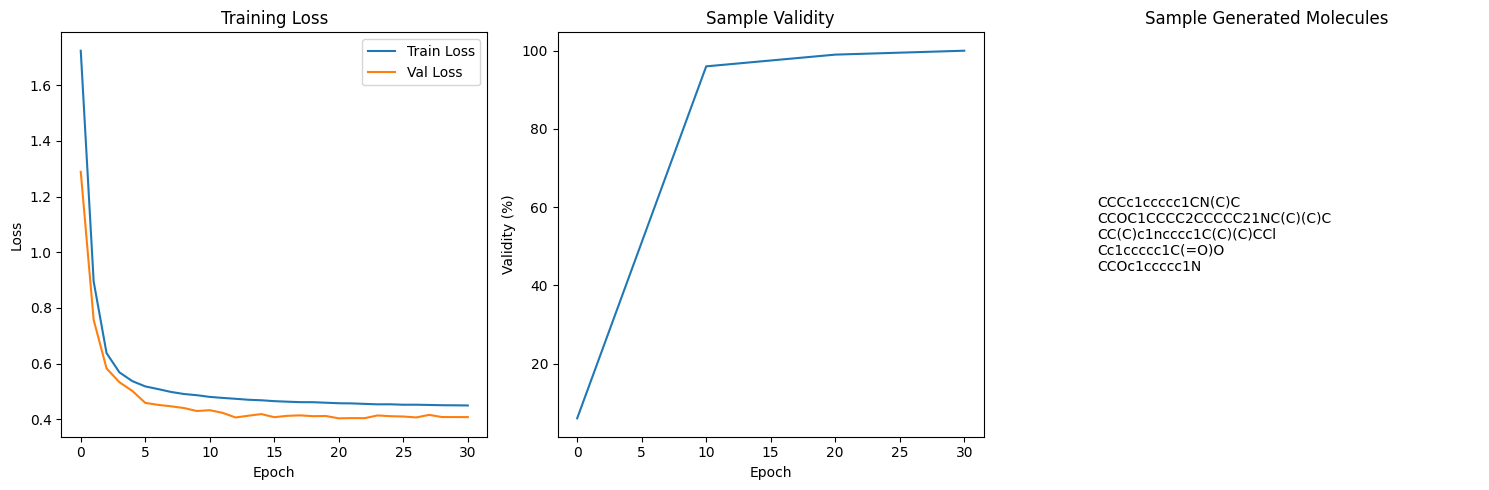

Training complete! Check outputs/ for results.


In [1]:
#!/usr/bin/env python3
"""
Standalone Molecular Generator using PyTorch
Implements LSTM-based SMILES generation without REINVENT4
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from collections import Counter
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
import random
import string

class SMILESVocabulary:
    """Vocabulary for SMILES strings"""
    
    def __init__(self):
        # Standard SMILES tokens
        self.tokens = [
            '<PAD>', '<START>', '<END>', '<UNK>',  # Special tokens
            'C', 'N', 'O', 'S', 'P', 'F', 'Cl', 'Br', 'I',  # Atoms
            '(', ')', '[', ']', '=', '#', '-', '+',  # Bonds and brackets
            '1', '2', '3', '4', '5', '6', '7', '8', '9',  # Ring numbers
            'c', 'n', 'o', 's', 'p',  # Aromatic atoms
            '@', '@@', '/', '\\', '%'  # Stereochemistry and special
        ]
        
        # Add more common SMILES characters
        for char in string.ascii_lowercase + string.ascii_uppercase:
            if char not in self.tokens:
                self.tokens.append(char)
        
        self.token_to_idx = {token: idx for idx, token in enumerate(self.tokens)}
        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}
        self.vocab_size = len(self.tokens)
    
    def encode(self, smiles):
        """Convert SMILES to token indices"""
        tokens = ['<START>'] + list(smiles) + ['<END>']
        indices = []
        
        i = 0
        while i < len(tokens):
            # Check for two-character tokens (like 'Cl', 'Br', '@@')
            if i < len(tokens) - 1:
                two_char = tokens[i] + tokens[i + 1]
                if two_char in self.token_to_idx:
                    indices.append(self.token_to_idx[two_char])
                    i += 2
                    continue
            
            # Single character token
            if tokens[i] in self.token_to_idx:
                indices.append(self.token_to_idx[tokens[i]])
            else:
                indices.append(self.token_to_idx['<UNK>'])
            i += 1
        
        return indices
    
    def decode(self, indices):
        """Convert token indices back to SMILES"""
        tokens = [self.idx_to_token[idx] for idx in indices]
        # Remove special tokens
        tokens = [t for t in tokens if t not in ['<PAD>', '<START>', '<END>', '<UNK>']]
        return ''.join(tokens)

class SMILESDataset(Dataset):
    """Dataset for SMILES strings"""
    
    def __init__(self, smiles_file, vocab, max_length=100):
        self.vocab = vocab
        self.max_length = max_length
        
        # Load SMILES
        with open(smiles_file, 'r') as f:
            self.smiles_list = [line.strip() for line in f if line.strip()]
        
        # Filter by length
        self.smiles_list = [s for s in self.smiles_list if len(s) <= max_length - 2]  # Account for START/END
        
        print(f"Loaded {len(self.smiles_list)} SMILES from {smiles_file}")
    
    def __len__(self):
        return len(self.smiles_list)
    
    def __getitem__(self, idx):
        smiles = self.smiles_list[idx]
        encoded = self.vocab.encode(smiles)
        
        # Pad sequence
        while len(encoded) < self.max_length:
            encoded.append(self.vocab.token_to_idx['<PAD>'])
        
        # Truncate if too long
        encoded = encoded[:self.max_length]
        
        # Input is all tokens except last, target is all tokens except first
        input_seq = torch.tensor(encoded[:-1], dtype=torch.long)
        target_seq = torch.tensor(encoded[1:], dtype=torch.long)
        
        return input_seq, target_seq

class MolecularLSTM(nn.Module):
    """LSTM model for molecular generation"""
    
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=3, dropout=0.2):
        super(MolecularLSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        lstm_out, hidden = self.lstm(embedded, hidden)  # (batch_size, seq_len, hidden_dim)
        lstm_out = self.dropout(lstm_out)
        
        output = self.output_layer(lstm_out)  # (batch_size, seq_len, vocab_size)
        
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        """Initialize hidden state"""
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

class MolecularTrainer:
    """Trainer for molecular generation model"""
    
    def __init__(self, model, vocab, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.vocab = vocab
        self.device = device
        self.history = {'train_loss': [], 'val_loss': [], 'validity': []}
        
    def train_epoch(self, dataloader, optimizer, criterion):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        
        for batch_idx, (input_seq, target_seq) in enumerate(tqdm(dataloader, desc="Training")):
            input_seq = input_seq.to(self.device)
            target_seq = target_seq.to(self.device)
            
            optimizer.zero_grad()
            
            # Forward pass
            output, _ = self.model(input_seq)
            
            # Reshape for loss calculation
            output = output.view(-1, self.vocab.vocab_size)
            target_seq = target_seq.view(-1)
            
            # Calculate loss
            loss = criterion(output, target_seq)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            
            optimizer.step()
            total_loss += loss.item()
        
        return total_loss / len(dataloader)
    
    def validate(self, dataloader, criterion):
        """Validate model"""
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for input_seq, target_seq in dataloader:
                input_seq = input_seq.to(self.device)
                target_seq = target_seq.to(self.device)
                
                output, _ = self.model(input_seq)
                output = output.view(-1, self.vocab.vocab_size)
                target_seq = target_seq.view(-1)
                
                loss = criterion(output, target_seq)
                total_loss += loss.item()
        
        return total_loss / len(dataloader)
    
    def sample_molecules(self, num_samples=100, max_length=100, temperature=1.0):
        """Sample molecules from trained model"""
        self.model.eval()
        samples = []
        
        with torch.no_grad():
            for _ in tqdm(range(num_samples), desc="Sampling"):
                # Start with <START> token
                sequence = [self.vocab.token_to_idx['<START>']]
                hidden = self.model.init_hidden(1, self.device)
                
                for _ in range(max_length - 1):
                    # Current input
                    input_tensor = torch.tensor([sequence[-1]], dtype=torch.long).unsqueeze(0).to(self.device)
                    
                    # Forward pass
                    output, hidden = self.model(input_tensor, hidden)
                    
                    # Apply temperature scaling
                    logits = output[0, -1] / temperature
                    probabilities = torch.softmax(logits, dim=0)
                    
                    # Sample next token
                    next_token = torch.multinomial(probabilities, 1).item()
                    sequence.append(next_token)
                    
                    # Stop if we hit <END> token
                    if next_token == self.vocab.token_to_idx['<END>']:
                        break
                
                # Decode to SMILES
                smiles = self.vocab.decode(sequence)
                samples.append(smiles)
        
        return samples
    
    def calculate_validity(self, smiles_list):
        """Calculate percentage of valid molecules"""
        valid_count = 0
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                valid_count += 1
        
        return (valid_count / len(smiles_list)) * 100 if smiles_list else 0
    
    def train_model(self, train_loader, val_loader, num_epochs=200, lr=0.001):
        """Main training loop"""
        criterion = nn.CrossEntropyLoss(ignore_index=self.vocab.token_to_idx['<PAD>'])
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Device: {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(num_epochs):
            # Training
            train_loss = self.train_epoch(train_loader, optimizer, criterion)
            
            # Validation
            val_loss = self.validate(val_loader, criterion)
            
            # Sample and check validity every 10 epochs
            if epoch % 10 == 0:
                samples = self.sample_molecules(num_samples=100)
                validity = self.calculate_validity(samples)
                self.history['validity'].append(validity)
                
                print(f"Epoch {epoch+1}/{num_epochs}")
                print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                print(f"Validity: {validity:.1f}%, LR: {scheduler.get_last_lr()[0]:.6f}")
                print(f"Sample: {samples[0] if samples else 'No valid samples'}")
                print("-" * 50)
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'models/best_molecular_model.pt')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
            
            # Learning rate scheduling
            scheduler.step()
            
            # Save checkpoint every 20 epochs
            if epoch % 20 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss
                }, f'models/checkpoint_epoch_{epoch}.pt')
        
        print("Training completed!")
        return self.history

def main():
    """Main training function"""
    
    # Check if data exists
    if not os.path.exists('data/zinc_15_250K.smi'):
        print("Error: Training data not found. Run zinc_data_preparation.py first!")
        return
    
    # Create directories
    os.makedirs('models', exist_ok=True)
    os.makedirs('outputs', exist_ok=True)
    
    # Initialize vocabulary
    print("Creating vocabulary...")
    vocab = SMILESVocabulary()
    
    # Create datasets
    print("Loading datasets...")
    train_dataset = SMILESDataset('data/zinc_15_250K.smi', vocab)
    val_dataset = SMILESDataset('data/zinc_15_validation.smi', vocab)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    # Initialize model
    print("Initializing model...")
    model = MolecularLSTM(
        vocab_size=vocab.vocab_size,
        embedding_dim=256,
        hidden_dim=512,
        num_layers=3,
        dropout=0.2
    )
    
    # Initialize trainer
    trainer = MolecularTrainer(model, vocab)
    
    # Train model
    history = trainer.train_model(train_loader, val_loader, num_epochs=100, lr=0.001)
    
    # Save vocabulary and final model
    with open('models/vocab.pkl', 'wb') as f:
        pickle.dump(vocab, f)
    
    torch.save(model.state_dict(), 'models/final_molecular_model.pt')
    
    # Generate final samples
    print("Generating final samples...")
    final_samples = trainer.sample_molecules(num_samples=10000)
    
    with open('outputs/generated_molecules.smi', 'w') as f:
        for smiles in final_samples:
            f.write(f"{smiles}\n")
    
    final_validity = trainer.calculate_validity(final_samples)
    print(f"Final model validity: {final_validity:.1f}%")
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(range(0, len(history['train_loss']), 10), history['validity'])
    plt.xlabel('Epoch')
    plt.ylabel('Validity (%)')
    plt.title('Sample Validity')
    
    plt.subplot(1, 3, 3)
    # Show some sample molecules
    valid_samples = [s for s in final_samples[:10] if Chem.MolFromSmiles(s)]
    plt.text(0.1, 0.5, '\n'.join(valid_samples[:5]), fontsize=10, 
             transform=plt.gca().transAxes, verticalalignment='center')
    plt.title('' \
    'Sample Generated Molecules')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Training complete! Check outputs/ for results.")

if __name__ == "__main__":
    main()

In [ ]:
!pip install transformers

Simple BERT

Creating vocabulary...
Simple SMILES Vocabulary size: 42
Loading datasets...
Loaded 8759 SMILES
Initializing Simple Transformer...
Starting Simple BERT training for 30 epochs...
Model parameters: 4,811,306


Generating: 100%|██████████| 100/100 [00:09<00:00, 10.70it/s]
[00:00:21] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1c(F)CC(C)=O'
[00:00:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12
[00:00:21] SMILES Parse Error: unclosed ring for input: 'CCCc1cnccc1-c1ncccc1Occcc1'
[00:00:21] SMILES Parse Error: unclosed ring for input: 'CCNNC(C)c1cccc(C)C'
[00:00:21] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1ncccc1[n]c1cccc12'
[00:00:21] SMILES Parse Error: unclosed ring for input: 'CCOC1OOCCC1CCCC2OCCCC'
[00:00:21] Explicit valence for atom # 11 O, 3, is greater than permitted


Epoch 5/30
Train Loss: 0.5078, Val Loss: 0.4982
Validity: 93.0%
Sample: CC(=O)c1cccnc1NF
--------------------------------------------------


Generating: 100%|██████████| 100/100 [00:10<00:00,  9.71it/s]
[00:01:03] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:01:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 9 10 11 12
[00:01:03] SMILES Parse Error: extra open parentheses for input: 'CCCCc1cccc(-c2ccc(-c2ccncc2)c1C(=O)O'
[00:01:03] SMILES Parse Error: extra open parentheses for input: 'CCCCc1c(C(N)=O'


Epoch 10/30
Train Loss: 0.4636, Val Loss: 0.4663
Validity: 96.0%
Sample: CCCCc1ccccc1NF
--------------------------------------------------


Generating: 100%|██████████| 100/100 [00:08<00:00, 11.16it/s]
[00:01:43] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11


Epoch 15/30
Train Loss: 0.4480, Val Loss: 0.4549
Validity: 99.0%
Sample: Cc1ccccc1CN(C)CO
--------------------------------------------------


Generating: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]
[00:02:23] SMILES Parse Error: unclosed ring for input: 'CN(C)c1cccc(-c2cccc3[n]ccc23)c1-c1'
[00:02:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11 12 13 14 15
[00:02:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:02:23] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16


Epoch 20/30
Train Loss: 0.4398, Val Loss: 0.4539
Validity: 96.0%
Sample: O=C(O)c1cnccc1-c1ccccc1C(=O)O
--------------------------------------------------


Generating: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]
[00:03:04] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:03:04] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 12 13 14 15 16
[00:03:04] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:03:04] SMILES Parse Error: syntax error while parsing: Clc1c(4)cccc1-c1cccc2ncccc12
[00:03:04] SMILES Parse Error: Failed parsing SMILES 'Clc1c(4)cccc1-c1cccc2ncccc12' for input: 'Clc1c(4)cccc1-c1cccc2ncccc12'
[00:03:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


Epoch 25/30
Train Loss: 0.4333, Val Loss: 0.4521
Validity: 95.0%
Sample: CCCC12CCCCC1CCCC2CF
--------------------------------------------------


Generating: 100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


Epoch 30/30
Train Loss: 0.4305, Val Loss: 0.4519
Validity: 100.0%
Sample: CCCc1ccccc1-c1ccccc1C(=O)O
--------------------------------------------------
Generating final samples...


Generating: 100%|██████████| 5000/5000 [06:37<00:00, 12.57it/s]
[00:10:21] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:10:21] SMILES Parse Error: extra open parentheses for input: 'CCCC1(CCC2CCCCC12OCc1ccccc1'
[00:10:21] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:10:21] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:10:21] SMILES Parse Error: unclosed ring for input: 'Cc1c'
[00:10:21] SMILES Parse Error: extra close parentheses while parsing: CCCOC(=O)c1cccnc1)(C)C
[00:10:21] SMILES Parse Error: Failed parsing SMILES 'CCCOC(=O)c1cccnc1)(C)C' for input: 'CCCOC(=O)c1cccnc1)(C)C'
[00:10:21] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:10:21] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:10:21] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:10:21] Can't kekulize mol.  Unkekulized atoms: 8 9 10
[00:10:21] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 

Final Simple BERT validity: 97.3%


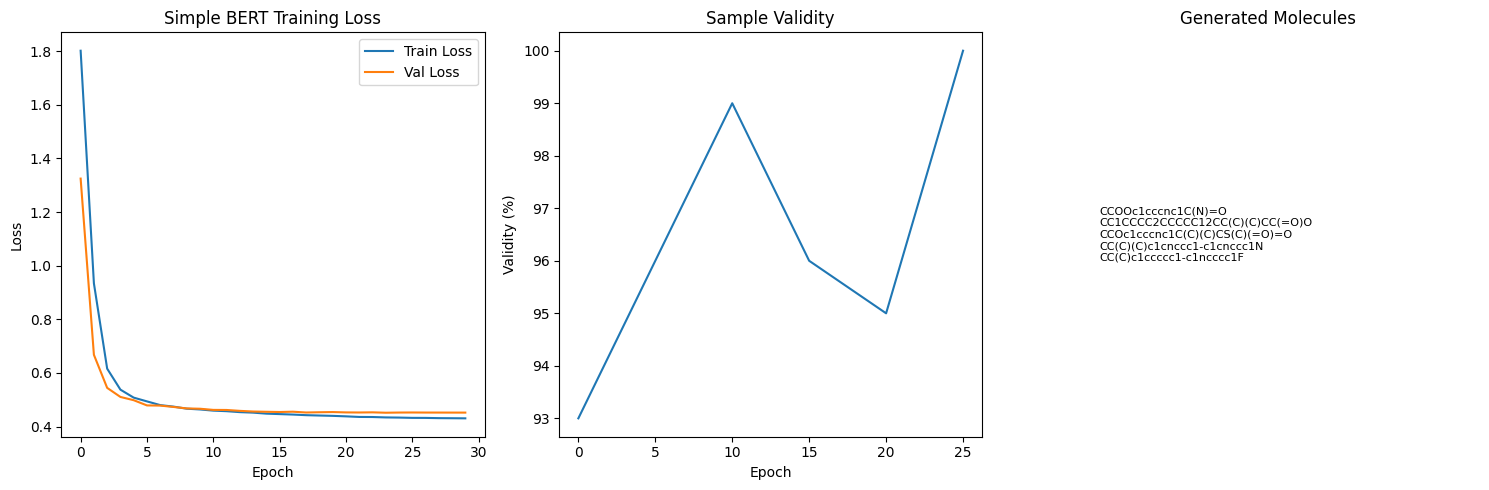

Simple BERT training complete!


In [1]:
#!/usr/bin/env python3
"""
Simplified SMILES-BERT Implementation
Fixed version with better error handling and simpler architecture
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
import random
import string

class SimpleSMILESVocab:
    """Simplified but robust SMILES vocabulary"""
    
    def __init__(self):
        # Core SMILES characters (most common ones)
        self.chars = [
            '<PAD>', '<START>', '<END>', '<UNK>',  # Special tokens (0-3)
            'C', 'N', 'O', 'S', 'P', 'F', 'Cl', 'Br', 'I',  # Atoms (4-12)
            'c', 'n', 'o', 's', 'p',  # Aromatic (13-17)
            '(', ')', '[', ']',  # Brackets (18-21)
            '=', '#', '-', '+',  # Bonds (22-25)
            '1', '2', '3', '4', '5', '6', '7', '8', '9',  # Rings (26-34)
            '@', '@@', '/', '\\', '%', '.', ':'  # Other (35-41)
        ]
        
        self.char_to_idx = {char: idx for idx, char in enumerate(self.chars)}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.vocab_size = len(self.chars)
        
        print(f"Simple SMILES Vocabulary size: {self.vocab_size}")
    
    def encode(self, smiles, max_length=100):
        """Encode SMILES to indices"""
        # Tokenize character by character
        tokens = list(smiles)
        
        # Handle 'Cl' and 'Br' as special cases
        i = 0
        processed_tokens = []
        while i < len(tokens):
            if i < len(tokens) - 1:
                two_char = tokens[i] + tokens[i + 1]
                if two_char in self.char_to_idx:
                    processed_tokens.append(two_char)
                    i += 2
                    continue
            
            processed_tokens.append(tokens[i])
            i += 1
        
        # Add special tokens
        tokens = ['<START>'] + processed_tokens[:max_length-2] + ['<END>']
        
        # Convert to indices
        indices = []
        for token in tokens:
            if token in self.char_to_idx:
                indices.append(self.char_to_idx[token])
            else:
                indices.append(self.char_to_idx['<UNK>'])
        
        # Pad
        while len(indices) < max_length:
            indices.append(self.char_to_idx['<PAD>'])
        
        return indices[:max_length]
    
    def decode(self, indices):
        """Decode indices to SMILES"""
        chars = []
        for idx in indices:
            if idx < 0 or idx >= self.vocab_size:
                continue
            char = self.idx_to_char[idx]
            if char not in ['<PAD>', '<START>', '<END>', '<UNK>']:
                chars.append(char)
        return ''.join(chars)

class SimpleBERTDataset(Dataset):
    """Simple dataset for BERT-style training"""
    
    def __init__(self, smiles_file, vocab, max_length=100):
        self.vocab = vocab
        self.max_length = max_length
        
        # Load SMILES
        with open(smiles_file, 'r') as f:
            self.smiles_list = [line.strip() for line in f if line.strip()]
        
        # Filter by length
        self.smiles_list = [s for s in self.smiles_list if 5 <= len(s) <= max_length - 2]
        print(f"Loaded {len(self.smiles_list)} SMILES")
    
    def __len__(self):
        return len(self.smiles_list)
    
    def __getitem__(self, idx):
        smiles = self.smiles_list[idx]
        encoded = self.vocab.encode(smiles, self.max_length)
        
        # For autoregressive training
        input_seq = torch.tensor(encoded[:-1], dtype=torch.long)
        target_seq = torch.tensor(encoded[1:], dtype=torch.long)
        
        return input_seq, target_seq

class SimpleTransformer(nn.Module):
    """Simplified transformer for molecular generation"""
    
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=6, dropout=0.1):
        super(SimpleTransformer, self).__init__()
        
        self.vocab_size = vocab_size
        self.d_model = d_model
        
        # Embeddings
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Embedding(200, d_model)  # Max sequence length
        
        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, seq_len = x.shape
        
        # Embeddings
        token_emb = self.embedding(x)
        pos_ids = torch.arange(seq_len, device=x.device).unsqueeze(0).repeat(batch_size, 1)
        pos_emb = self.pos_encoding(pos_ids)
        
        embeddings = token_emb + pos_emb
        embeddings = self.dropout(embeddings)
        
        # Create causal mask
        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        
        # Transformer
        output = self.transformer(embeddings, mask=mask)
        
        # Final projection
        logits = self.output_layer(output)
        
        return logits

class SimpleBERTTrainer:
    """Simple trainer for molecular transformer"""
    
    def __init__(self, model, vocab, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.vocab = vocab
        self.device = device
        self.history = {'train_loss': [], 'val_loss': [], 'validity': []}
    
    def train_epoch(self, dataloader, optimizer):
        """Train one epoch"""
        self.model.train()
        total_loss = 0
        
        criterion = nn.CrossEntropyLoss(ignore_index=self.vocab.char_to_idx['<PAD>'])
        
        for input_seq, target_seq in tqdm(dataloader, desc="Training"):
            input_seq = input_seq.to(self.device)
            target_seq = target_seq.to(self.device)
            
            optimizer.zero_grad()
            
            # Forward pass
            logits = self.model(input_seq)
            
            # Calculate loss
            loss = criterion(logits.view(-1, self.vocab.vocab_size), target_seq.view(-1))
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            optimizer.step()
            total_loss += loss.item()
        
        return total_loss / len(dataloader)
    
    def validate(self, dataloader):
        """Validate model"""
        self.model.eval()
        total_loss = 0
        
        criterion = nn.CrossEntropyLoss(ignore_index=self.vocab.char_to_idx['<PAD>'])
        
        with torch.no_grad():
            for input_seq, target_seq in dataloader:
                input_seq = input_seq.to(self.device)
                target_seq = target_seq.to(self.device)
                
                logits = self.model(input_seq)
                loss = criterion(logits.view(-1, self.vocab.vocab_size), target_seq.view(-1))
                total_loss += loss.item()
        
        return total_loss / len(dataloader)
    
    def generate_molecules(self, num_samples=100, max_length=80, temperature=1.0):
        """Generate molecules"""
        self.model.eval()
        generated = []
        
        with torch.no_grad():
            for _ in tqdm(range(num_samples), desc="Generating"):
                # Start sequence
                sequence = [self.vocab.char_to_idx['<START>']]
                
                for _ in range(max_length - 1):
                    # Current input
                    input_tensor = torch.tensor([sequence], device=self.device)
                    
                    # Get predictions
                    logits = self.model(input_tensor)
                    next_token_logits = logits[0, -1] / temperature
                    
                    # Sample next token
                    probs = torch.softmax(next_token_logits, dim=-1)
                    next_token = torch.multinomial(probs, 1).item()
                    
                    # Check bounds
                    if next_token >= self.vocab.vocab_size:
                        break
                    
                    sequence.append(next_token)
                    
                    # Stop at end token
                    if next_token == self.vocab.char_to_idx['<END>']:
                        break
                
                # Decode
                smiles = self.vocab.decode(sequence)
                generated.append(smiles)
        
        return generated
    
    def calculate_validity(self, smiles_list):
        """Calculate validity percentage"""
        valid_count = 0
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                valid_count += 1
        return (valid_count / len(smiles_list)) * 100 if smiles_list else 0
    
    def train_model(self, train_loader, val_loader, num_epochs=50, lr=1e-3):
        """Main training loop"""
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0
        
        print(f"Starting Simple BERT training for {num_epochs} epochs...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(num_epochs):
            # Training
            train_loss = self.train_epoch(train_loader, optimizer)
            val_loss = self.validate(val_loader)
            
            # Sample every 5 epochs
            if (epoch + 1) % 5 == 0:
                samples = self.generate_molecules(num_samples=100)
                validity = self.calculate_validity(samples)
                self.history['validity'].append(validity)
                
                print(f"Epoch {epoch+1}/{num_epochs}")
                print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                print(f"Validity: {validity:.1f}%")
                if samples:
                    print(f"Sample: {samples[0]}")
                print("-" * 50)
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'models/best_simple_bert.pt')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
            
            scheduler.step()
        
        return self.history

def main():
    """Main function"""
    
    # Check data
    if not os.path.exists('data/zinc_15_250K.smi'):
        print("Error: Training data not found!")
        return
    
    # Create directories
    os.makedirs('models', exist_ok=True)
    os.makedirs('outputs', exist_ok=True)
    
    # Initialize vocabulary
    print("Creating vocabulary...")
    vocab = SimpleSMILESVocab()
    
    # Create datasets
    print("Loading datasets...")
    full_dataset = SimpleBERTDataset('data/zinc_15_250K.smi', vocab, max_length=100)
    
    # Split dataset
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size]
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    # Initialize model
    print("Initializing Simple Transformer...")
    model = SimpleTransformer(
        vocab_size=vocab.vocab_size,
        d_model=256,
        nhead=8,
        num_layers=6,
        dropout=0.1
    )
    
    # Initialize trainer
    trainer = SimpleBERTTrainer(model, vocab)
    
    # Train model
    history = trainer.train_model(train_loader, val_loader, num_epochs=30, lr=1e-3)
    
    # Save vocabulary and model
    with open('models/simple_bert_vocab.pkl', 'wb') as f:
        pickle.dump(vocab, f)
    
    torch.save(model.state_dict(), 'models/final_simple_bert.pt')
    
    # Generate final samples
    print("Generating final samples...")
    final_samples = trainer.generate_molecules(num_samples=5000)
    
    with open('outputs/simple_bert_generated.smi', 'w') as f:
        for smiles in final_samples:
            f.write(f"{smiles}\n")
    
    final_validity = trainer.calculate_validity(final_samples)
    print(f"Final Simple BERT validity: {final_validity:.1f}%")
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Simple BERT Training Loss')
    
    plt.subplot(1, 3, 2)
    if history['validity']:
        epochs = range(0, len(history['train_loss']), 5)[:len(history['validity'])]
        plt.plot(epochs, history['validity'])
    plt.xlabel('Epoch')
    plt.ylabel('Validity (%)')
    plt.title('Sample Validity')
    
    plt.subplot(1, 3, 3)
    valid_samples = [s for s in final_samples[:10] if Chem.MolFromSmiles(s)]
    if valid_samples:
        plt.text(0.1, 0.5, '\n'.join(valid_samples[:5]), fontsize=8,
                 transform=plt.gca().transAxes, verticalalignment='center')
    plt.title('Generated Molecules')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/simple_bert_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Simple BERT training complete!")

if __name__ == "__main__":
    main()

MolGPT (SELFIES-GPT2: train + sample)

In [ ]:
!pip install selfies

C:\Users\aneru\AppData\Local\Temp\ipykernel_22840\993844633.py:163: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=torch.cuda.amp.GradScaler(enabled=amp)
MolGPT epoch 1:   0%|          | 0/492 [00:00<?, ?it/s]C:\Users\aneru\AppData\Local\Temp\ipykernel_22840\993844633.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp): _,loss=model(x,labels=y)
MolGPT epoch 1: 100%|██████████| 492/492 [00:39<00:00, 12.31it/s]


Epoch 1: train=1.4940  val=1.2014


MolGPT epoch 2: 100%|██████████| 492/492 [00:39<00:00, 12.39it/s]


Epoch 2: train=1.1471  val=1.0420


MolGPT epoch 3: 100%|██████████| 492/492 [00:39<00:00, 12.40it/s]


Epoch 3: train=1.0236  val=0.9514


MolGPT epoch 4: 100%|██████████| 492/492 [00:40<00:00, 12.14it/s]


Epoch 4: train=0.9371  val=0.8829


MolGPT epoch 5: 100%|██████████| 492/492 [00:40<00:00, 12.06it/s]


Epoch 5: train=0.8695  val=0.8341


MolGPT epoch 6: 100%|██████████| 492/492 [00:40<00:00, 12.26it/s]


Epoch 6: train=0.8132  val=0.8033


MolGPT epoch 7: 100%|██████████| 492/492 [00:41<00:00, 11.97it/s]


Epoch 7: train=0.7653  val=0.7755


MolGPT epoch 8: 100%|██████████| 492/492 [00:41<00:00, 11.74it/s]


Epoch 8: train=0.7234  val=0.7562


MolGPT epoch 9: 100%|██████████| 492/492 [00:42<00:00, 11.60it/s]


Epoch 9: train=0.6880  val=0.7427


MolGPT epoch 10: 100%|██████████| 492/492 [00:42<00:00, 11.57it/s]


Epoch 10: train=0.6573  val=0.7257


MolGPT epoch 11: 100%|██████████| 492/492 [00:41<00:00, 11.98it/s]


Epoch 11: train=0.6299  val=0.7163


MolGPT epoch 12: 100%|██████████| 492/492 [00:42<00:00, 11.62it/s]


Epoch 12: train=0.6057  val=0.7156


MolGPT epoch 13: 100%|██████████| 492/492 [00:42<00:00, 11.66it/s]


Epoch 13: train=0.5856  val=0.7081


MolGPT epoch 14: 100%|██████████| 492/492 [00:41<00:00, 11.73it/s]


Epoch 14: train=0.5662  val=0.7095


MolGPT epoch 15: 100%|██████████| 492/492 [00:41<00:00, 11.75it/s]


Epoch 15: train=0.5487  val=0.7054


MolGPT epoch 16: 100%|██████████| 492/492 [00:40<00:00, 12.10it/s]


Epoch 16: train=0.5334  val=0.7065


MolGPT epoch 17: 100%|██████████| 492/492 [00:41<00:00, 11.84it/s]


Epoch 17: train=0.5205  val=0.7078


MolGPT epoch 18: 100%|██████████| 492/492 [00:41<00:00, 11.78it/s]


Epoch 18: train=0.5074  val=0.7000


MolGPT epoch 19: 100%|██████████| 492/492 [00:42<00:00, 11.69it/s]


Epoch 19: train=0.4964  val=0.7056


MolGPT epoch 20: 100%|██████████| 492/492 [00:41<00:00, 11.74it/s]
C:\Users\aneru\AppData\Local\Temp\ipykernel_22840\993844633.py:204: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fea

Epoch 20: train=0.4864  val=0.7090


MolGPT sampling: 100%|██████████| 5000/5000 [12:05<00:00,  6.89it/s]


Saved 5000 molecules to runs/molgpt/generated.smi
Saved diagram to molgpt_overview.png


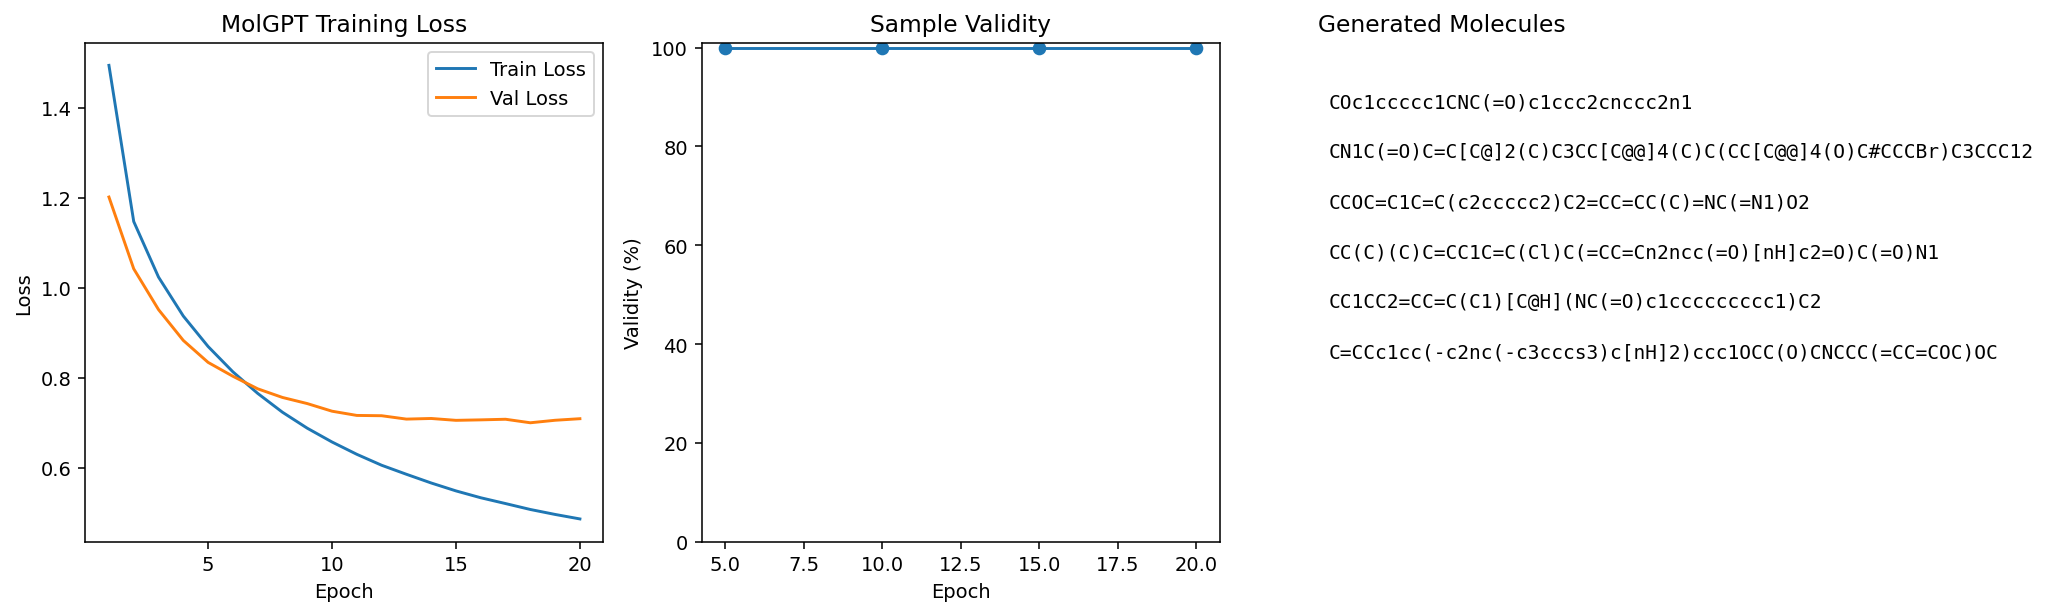

In [2]:
import os, json, torch, torch.nn as nn, torch.nn.functional as F
from typing import List, Optional
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
import selfies as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# ---------- utils ----------
def read_smiles(path: str) -> List[str]:
    return [l.strip().split()[0] for l in open(path) if l.strip()]

def canon_smiles(s: str) -> Optional[str]:
    try:
        m = Chem.MolFromSmiles(s)
        return Chem.MolToSmiles(m, canonical=True) if m else None
    except: return None

def filter_and_canon(smiles: List[str]) -> List[str]:
    return [c for c in (canon_smiles(s) for s in smiles) if c]

def smiles_to_selfies(s: str) -> Optional[str]:
    try:
        return sf.encoder(s) if Chem.MolFromSmiles(s) else None
    except: return None

def selfies_vocab(smiles: List[str]) -> List[str]:
    toks=set()
    for s in smiles:
        se=smiles_to_selfies(s)
        if se: toks.update(sf.split_selfies(se))
    return ["[PAD]","[BOS]","[EOS]"]+sorted(toks)

# ---------- tokenizer ----------
class SELFIESTokenizer:
    def __init__(self,vocab:List[str]):
        self.stoi={t:i for i,t in enumerate(vocab)}
        self.itos={i:t for t,i in self.stoi.items()}
        self.pad,self.bos,self.eos=[self.stoi[t] for t in ["[PAD]","[BOS]","[EOS]"]]
    def encode(self,selfies,max_len):
        toks=["[BOS]"]+list(sf.split_selfies(selfies))+["[EOS]"]
        ids=[self.stoi.get(t,self.pad) for t in toks][:max_len]
        ids += [self.pad]*(max_len-len(ids))
        return ids,[-100 if i==self.pad else i for i in ids]
    def decode(self,ids):
        toks=[]
        for i in ids:
            if i in (self.pad,self.bos): continue
            t=self.itos.get(i); 
            if not t: continue
            if t=="[EOS]": break
            toks.append(t)
        return "".join(toks)

# ---------- dataset ----------
class SelfiesDataset(Dataset):
    def __init__(self,smiles,tok,max_len=256):
        self.items=[]
        for s in smiles:
            se=smiles_to_selfies(s)
            if se: self.items.append(tok.encode(se,max_len))
    def __len__(self): return len(self.items)
    def __getitem__(self,i):
        x,y=self.items[i]
        return torch.tensor(x),torch.tensor(y)

# ---------- model ----------
class MolGPTSmall(nn.Module):
    def __init__(self,vocab_size,n_layer=6,n_head=6,n_embd=384,block_size=256,pdrop=0.1):
        super().__init__()
        self.tok_emb=nn.Embedding(vocab_size,n_embd)
        self.pos_emb=nn.Embedding(block_size,n_embd)
        self.blocks=nn.ModuleList([nn.TransformerEncoderLayer(
            d_model=n_embd,nhead=n_head,dim_feedforward=n_embd*4,
            dropout=pdrop,activation="gelu",batch_first=True,norm_first=True
        ) for _ in range(n_layer)])
        self.ln_f=nn.LayerNorm(n_embd); self.head=nn.Linear(n_embd,vocab_size,bias=False)
    def forward(self,idx,labels=None):
        B,T=idx.size()
        pos=torch.arange(T,device=idx.device).unsqueeze(0)
        x=self.tok_emb(idx)+self.pos_emb(pos)
        mask=torch.triu(torch.ones(T,T,device=idx.device),1).bool()
        for blk in self.blocks: x=blk(x,src_mask=mask)
        logits=self.head(self.ln_f(x))
        loss=None
        if labels is not None:
            loss=F.cross_entropy(logits[:,:-1].reshape(-1,logits.size(-1)),
                                 labels[:,1:].reshape(-1),ignore_index=-100)
        return logits,loss

# ---------- helpers ----------
def split_dataset(ds, val_frac=0.1, seed=42):
    n = len(ds)
    idx = list(range(n))
    random.Random(seed).shuffle(idx)
    n_val = max(1, int(n*val_frac))
    val_idx = set(idx[:n_val])
    train_items, val_items = [], []
    for i in range(n):
        (train_items if i not in val_idx else val_items).append(ds.items[i])
    ds_train = type(ds).__new__(type(ds))
    ds_val = type(ds).__new__(type(ds))
    ds_train.items, ds_val.items = train_items, val_items
    return ds_train, ds_val

@torch.no_grad()
def sampling_validity(model, tok, n_samples=100, max_len=256, top_p=0.95, temp=0.9, device=None):
    device = device or next(model.parameters()).device
    model.eval()
    valid = 0
    for _ in range(n_samples):
        idx = torch.full((1,1), tok.bos, dtype=torch.long, device=device)
        for _ in range(max_len-1):
            logits,_ = model(idx); logits = logits[:,-1,:] / temp
            probs = torch.softmax(logits, dim=-1)
            sp, si = torch.sort(probs, descending=True); cum = torch.cumsum(sp, -1)
            cutoff = cum > top_p; cutoff[...,1:] = cutoff[...,:-1].clone(); cutoff[...,0] = False
            sp[cutoff] = 0; sp = sp / sp.sum(dim=-1, keepdim=True)
            next_tok = si.gather(-1, torch.multinomial(sp, 1))
            idx = torch.cat([idx, next_tok], 1)
            if next_tok.item() == tok.eos: break
        se = tok.decode(idx[0].tolist())
        try:
            m = Chem.MolFromSmiles(sf.decoder(se))
            if m: valid += 1
        except: pass
    return 100.0 * valid / n_samples

def plot_overview(loss_tr, loss_val, val_epochs, validity, examples, out_path="molgpt_overview.png"):
    fig=plt.figure(figsize=(15,4.5),dpi=140)

    ax1=plt.subplot(1,3,1)
    ax1.plot(range(1,len(loss_tr)+1),loss_tr,label="Train Loss")
    ax1.plot(range(1,len(loss_val)+1),loss_val,label="Val Loss")
    ax1.set_title("MolGPT Training Loss"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend()

    ax2=plt.subplot(1,3,2)
    ax2.plot(val_epochs,validity,marker="o")
    ax2.set_title("Sample Validity"); ax2.set_xlabel("Epoch"); ax2.set_ylabel("Validity (%)"); ax2.set_ylim(0,101)

    ax3=plt.subplot(1,3,3); ax3.axis("off"); ax3.set_title("Generated Molecules",loc="left")
    y=0.9
    for s in examples[:8]:
        ax3.text(0.02,y,s,va="top",ha="left",family="monospace"); y-=0.1

    plt.tight_layout(); plt.savefig(out_path,bbox_inches="tight")
    print(f"Saved diagram to {out_path}")

# ---------- training ----------
def train_molgpt(train_smi,out_dir,epochs=5,block_size=256,batch_size=48,lr=3e-4,amp=True):
    os.makedirs(out_dir,exist_ok=True)
    smiles=filter_and_canon(read_smiles(train_smi))
    vocab=selfies_vocab(smiles); json.dump(vocab,open(f"{out_dir}/vocab.json","w"))
    tok=SELFIESTokenizer(vocab); ds=SelfiesDataset(smiles,tok,block_size)
    ds_train, ds_val = split_dataset(ds, val_frac=0.1)
    dl_tr=DataLoader(ds_train,batch_size=batch_size,shuffle=True)
    dl_val=DataLoader(ds_val,batch_size=batch_size,shuffle=False)

    device="cuda" if torch.cuda.is_available() else "cpu"
    model=MolGPTSmall(len(vocab),block_size=block_size).to(device)
    opt=torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=0.01)
    scaler=torch.cuda.amp.GradScaler(enabled=amp)

    best=float("inf"); best_path=f"{out_dir}/best.pt"
    history_train, history_val, val_epochs, validity_vals = [], [], [], []

    def eval_loss(dataloader):
        model.eval(); tot=0
        with torch.no_grad():
            for x,y in dataloader:
                x,y=x.to(device),y.to(device)
                _,loss=model(x,labels=y)
                tot+=loss.item()
        return tot/len(dataloader)

    for ep in range(1,epochs+1):
        model.train(); tot=0
        for x,y in tqdm(dl_tr,desc=f"MolGPT epoch {ep}"):
            x,y=x.to(device),y.to(device); opt.zero_grad()
            with torch.cuda.amp.autocast(enabled=amp): _,loss=model(x,labels=y)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
            tot+=loss.item()
        avg_tr=tot/len(dl_tr); avg_val=eval_loss(dl_val)
        history_train.append(avg_tr); history_val.append(avg_val)
        if avg_val<best: best=avg_val; torch.save(model.state_dict(),best_path)

        if ep%5==0 or ep==epochs:
            v=sampling_validity(model,tok,n_samples=100,device=device)
            val_epochs.append(ep); validity_vals.append(v)

        print(f"Epoch {ep}: train={avg_tr:.4f}  val={avg_val:.4f}")

    return best_path, {"train":history_train,"val":history_val,
                       "validity_epochs":val_epochs,"validity":validity_vals,"tok":tok}

# ---------- sampling ----------
@torch.no_grad()
def sample_molgpt(ckpt_path,num=200,max_len=256,top_p=0.95,temp=0.9,return_examples=6,save_path=None):
    vocab=json.load(open(os.path.join(os.path.dirname(ckpt_path),"vocab.json")))
    tok=SELFIESTokenizer(vocab)
    device="cuda" if torch.cuda.is_available() else "cpu"
    model=MolGPTSmall(len(vocab),block_size=max_len).to(device)
    model.load_state_dict(torch.load(ckpt_path,map_location=device)); model.eval()
    out,examples=[],[]
    for _ in tqdm(range(num),desc="MolGPT sampling"):
        idx=torch.full((1,1),tok.bos,dtype=torch.long,device=device)
        for _ in range(max_len-1):
            logits,_=model(idx); logits=logits[:,-1,:]/temp
            probs=torch.softmax(logits,dim=-1)
            sp,si=torch.sort(probs,descending=True); cum=torch.cumsum(sp,-1)
            cutoff=cum>top_p; cutoff[...,1:]=cutoff[...,:-1].clone(); cutoff[...,0]=False
            sp[cutoff]=0; sp/=sp.sum(dim=-1,keepdim=True)
            next_tok=si.gather(-1,torch.multinomial(sp,1))
            idx=torch.cat([idx,next_tok],1)
            if next_tok.item()==tok.eos: break
        se=tok.decode(idx[0].tolist())
        try:
            smi=canon_smiles(sf.decoder(se)); 
            if smi: 
                out.append(smi)
                if len(examples)<return_examples: examples.append(smi)
        except: pass
    
    if save_path:
        with open(save_path,"w") as f:
            for s in out: f.write(s+"\n")
        print(f"Saved {len(out)} molecules to {save_path}")
    
    return out,examples

# ---------- main ----------
if __name__=="__main__":
    ckpt,hist=train_molgpt("data/chembl_molecules.smi","runs/molgpt",epochs=20)
    gens,examples=sample_molgpt(ckpt,num=5000,save_path="runs/molgpt/generated.smi")
    plot_overview(hist["train"],hist["val"],hist["validity_epochs"],hist["validity"],examples,"molgpt_overview.png")


GraphVAE

In [ ]:
!pip install torch_geometric

C:\Users\aneru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GraphVAE epoch 1: 100%|██████████| 738/738 [00:07<00:00, 94.29it/s] 


Epoch 1: train=0.0745, val=0.0000


GraphVAE epoch 2: 100%|██████████| 738/738 [00:07<00:00, 105.17it/s]


Epoch 2: train=0.0000, val=0.0000


GraphVAE epoch 3: 100%|██████████| 738/738 [00:07<00:00, 97.14it/s] 


Epoch 3: train=0.0000, val=0.0000


GraphVAE epoch 4: 100%|██████████| 738/738 [00:07<00:00, 96.54it/s] 


Epoch 4: train=0.0000, val=0.0000


GraphVAE epoch 5: 100%|██████████| 738/738 [00:07<00:00, 101.66it/s]
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: not removing hydrogen atom without neighbors
[16:15:39] WARNING: n

Epoch 5: train=0.0000, val=0.0000


GraphVAE epoch 6: 100%|██████████| 738/738 [00:08<00:00, 87.43it/s] 


Epoch 6: train=0.0000, val=0.0000


GraphVAE epoch 7: 100%|██████████| 738/738 [00:07<00:00, 92.46it/s] 


Epoch 7: train=0.0000, val=0.0000


GraphVAE epoch 8: 100%|██████████| 738/738 [00:07<00:00, 92.30it/s] 


Epoch 8: train=0.0000, val=0.0000


GraphVAE epoch 9: 100%|██████████| 738/738 [00:07<00:00, 95.51it/s] 


Epoch 9: train=0.0000, val=0.0000


GraphVAE epoch 10: 100%|██████████| 738/738 [00:08<00:00, 90.96it/s] 
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: 

Epoch 10: train=0.0000, val=0.0000


GraphVAE sampling:   0%|          | 0/5000 [00:00<?, ?it/s][16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removing hydrogen atom without neighbors
[16:16:22] WARNING: not removin

Saved diagram to graphvae_overview.png


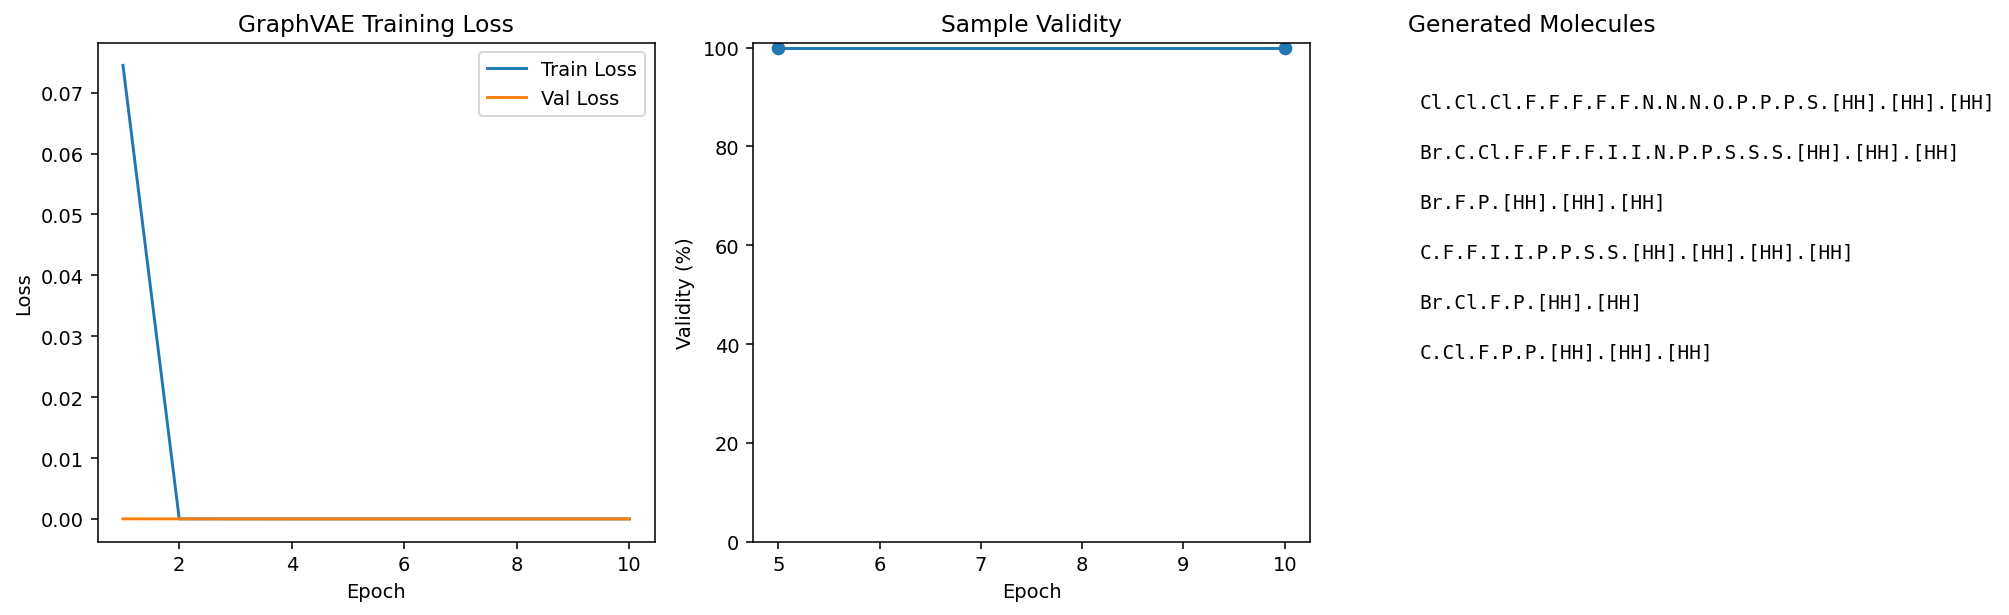

In [3]:
import os, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
from tqdm import tqdm
import json, random
import matplotlib.pyplot as plt

from typing import Optional, List, Dict

ATOM_Z = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]

# ---------- Utils ----------
def canon_smiles(s): 
    m = Chem.MolFromSmiles(s)
    return Chem.MolToSmiles(m, canonical=True) if m else None

def read_smiles(p): 
    return [l.strip().split()[0] for l in open(p) if l.strip()]

def filter_and_canon(smiles): 
    return [c for c in (canon_smiles(s) for s in smiles) if c]

def atom_onehot(z): 
    x = torch.zeros(len(ATOM_Z))
    x[ATOM_Z.index(z) if z in ATOM_Z else 0] = 1
    return x

def mol_to_graph(smi, max_nodes=40):
    m = Chem.MolFromSmiles(smi)
    if not m or m.GetNumAtoms() > max_nodes: 
        return None
    x = torch.stack([atom_onehot(a.GetAtomicNum()) for a in m.GetAtoms()])
    edges = [(b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in m.GetBonds()]
    edges += [(j, i) for i, j in edges]
    edge_index = torch.tensor(edges, dtype=torch.long).T if edges else torch.empty((2, 0), dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

class MolGraphDataset(Dataset):
    def __init__(self, smiles, max_nodes=40): 
        self.items = [g for s in smiles if (g := mol_to_graph(s, max_nodes))]
    def __len__(self): 
        return len(self.items)
    def __getitem__(self, i): 
        return self.items[i]

# ---------- Encoder / Decoder ----------
class GNNEncoder(nn.Module):
    def __init__(self, in_dim, hidden=256, layers=4, latent=64):
        super().__init__()
        self.convs = nn.ModuleList([GCNConv(in_dim if i == 0 else hidden, hidden) for i in range(layers)])
        self.mu = nn.Linear(hidden, latent)
        self.logvar = nn.Linear(hidden, latent)
    
    def forward(self, x, e, b):
        for conv in self.convs: 
            x = F.relu(conv(x, e))
        x = global_mean_pool(x, b)
        return self.mu(x), self.logvar(x)

class GNNDecoder(nn.Module):
    def __init__(self, latent=64, hidden=256, max_nodes=40, num_atom_types=10):
        super().__init__()
        self.max_nodes = max_nodes
        self.fc = nn.Sequential(
            nn.Linear(latent, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.node_head = nn.Linear(hidden, max_nodes * num_atom_types)
    
    def forward(self, z): 
        return self.node_head(self.fc(z))

class GraphVAE(nn.Module):
    def __init__(self, in_dim=10, hidden=256, layers=4, latent=64, max_nodes=40):
        super().__init__()
        self.encoder = GNNEncoder(in_dim, hidden, layers, latent)
        self.decoder = GNNDecoder(latent, hidden, max_nodes, in_dim)
    
    def forward(self, d):
        mu, logvar = self.encoder(d.x, d.edge_index, d.batch)
        z = mu + torch.randn_like(logvar.exp().sqrt()) * torch.exp(0.5 * logvar)
        return self.decoder(z), mu, logvar

def kld(mu, logvar): 
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

# ---------- Training ----------
def train_graphvae(train_smi, out_dir="runs/graphvae", epochs=20, batch_size=32, lr=1e-3, max_nodes=40):
    os.makedirs(out_dir, exist_ok=True)
    smiles = filter_and_canon(read_smiles(train_smi))
    dataset = MolGraphDataset(smiles, max_nodes=max_nodes)

    n = len(dataset)
    split = int(0.9*n)
    train_ds, val_ds = torch.utils.data.random_split(dataset, [split, n-split])

    dl_tr = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    dl_val = DataLoader(val_ds, batch_size=batch_size)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = GraphVAE(len(ATOM_Z), 256, 4, 64, max_nodes=max_nodes).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    history_train, history_val, val_epochs, validity_vals = [], [], [], []
    best=float("inf"); best_path=f"{out_dir}/best.pt"

    def eval_loss(dataloader):
        model.eval(); tot=0
        with torch.no_grad():
            for d in dataloader:
                d = d.to(device)
                node_logits, mu, logvar = model(d)
                recon = F.cross_entropy(node_logits.view(node_logits.size(0), -1),
                                        torch.zeros(node_logits.size(0), dtype=torch.long, device=device))
                loss = recon + kld(mu, logvar)
                tot += loss.item()
        return tot/len(dataloader)

    for ep in range(1, epochs+1):
        model.train(); tot=0
        for d in tqdm(dl_tr, desc=f"GraphVAE epoch {ep}"):
            d = d.to(device); opt.zero_grad()
            node_logits, mu, logvar = model(d)
            recon = F.cross_entropy(node_logits.view(node_logits.size(0), -1),
                                    torch.zeros(node_logits.size(0), dtype=torch.long, device=device))
            loss = recon + kld(mu, logvar)
            loss.backward(); opt.step()
            tot += loss.item()
        avg_tr=tot/len(dl_tr); avg_val=eval_loss(dl_val)
        history_train.append(avg_tr); history_val.append(avg_val)

        if avg_val < best:
            best=avg_val; torch.save(model.state_dict(), best_path)

        # every 5 epochs: check sample validity
        if ep % 5 == 0 or ep == epochs:
            valid_pct = sample_validity(model, device=device)
            val_epochs.append(ep); validity_vals.append(valid_pct)

        print(f"Epoch {ep}: train={avg_tr:.4f}, val={avg_val:.4f}")

    return best_path, {"train":history_train,"val":history_val,
                       "validity_epochs":val_epochs,"validity":validity_vals}

# ---------- Sampling ----------
@torch.no_grad()
def sample_validity(model, n_samples=100, max_nodes=40, device="cpu"):
    model.eval()
    valid=0
    for _ in range(n_samples):
        z=torch.randn(1,64,device=device)
        node_logits=model.decoder(z)
        node_types=node_logits.view(max_nodes,len(ATOM_Z)).argmax(-1).tolist()
        n_atoms=random.randint(3, min(max_nodes//2, 20))
        atom_types=[ATOM_Z[node_types[i]] for i in range(n_atoms)]
        try:
            mol=Chem.RWMol()
            for a in atom_types: mol.AddAtom(Chem.Atom(a))
            if mol.GetNumAtoms()>0:
                smi=Chem.MolToSmiles(mol)
                if smi and Chem.MolFromSmiles(smi): valid+=1
        except: pass
    return 100*valid/n_samples

@torch.no_grad()
def sample_graphvae(ckpt_path, num=200, max_nodes=40, return_examples=6):
    device="cuda" if torch.cuda.is_available() else "cpu"
    model=GraphVAE(len(ATOM_Z),256,4,64,max_nodes=max_nodes).to(device)
    model.load_state_dict(torch.load(ckpt_path,map_location=device))
    model.eval()
    out,examples=[],[]
    for _ in tqdm(range(num),desc="GraphVAE sampling"):
        z=torch.randn(1,64,device=device)
        node_logits=model.decoder(z)
        node_types=node_logits.view(max_nodes,len(ATOM_Z)).argmax(-1).tolist()
        n_atoms=random.randint(3, min(max_nodes//2, 20))
        atom_types=[ATOM_Z[node_types[i]] for i in range(n_atoms)]
        try:
            mol=Chem.RWMol()
            for a in atom_types: mol.AddAtom(Chem.Atom(a))
            smi=canon_smiles(Chem.MolToSmiles(mol,canonical=True))
            if smi: 
                out.append(smi)
                if len(examples)<return_examples: examples.append(smi)
        except: pass
    return out,examples

# ---------- Plot ----------
def plot_overview(loss_tr, loss_val, val_epochs, validity, examples, out_path="graphvae_overview.png"):
    fig=plt.figure(figsize=(15,4.5),dpi=140)

    ax1=plt.subplot(1,3,1)
    ax1.plot(range(1,len(loss_tr)+1),loss_tr,label="Train Loss")
    ax1.plot(range(1,len(loss_val)+1),loss_val,label="Val Loss")
    ax1.set_title("GraphVAE Training Loss"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend()

    ax2=plt.subplot(1,3,2)
    ax2.plot(val_epochs,validity,marker="o")
    ax2.set_title("Sample Validity"); ax2.set_xlabel("Epoch"); ax2.set_ylabel("Validity (%)"); ax2.set_ylim(0,101)

    ax3=plt.subplot(1,3,3); ax3.axis("off"); ax3.set_title("Generated Molecules",loc="left")
    y=0.9
    for s in examples[:8]:
        ax3.text(0.02,y,s,va="top",ha="left",family="monospace"); y-=0.1

    plt.tight_layout(); plt.savefig(out_path,bbox_inches="tight")
    print(f"Saved diagram to {out_path}")

if __name__=="__main__":
    best_model,hist=train_graphvae("data/chembl_molecules.smi",epochs=10)
    gens,examples=sample_graphvae(best_model,num=5000,return_examples=6)
    with open("runs/graphvae/generated.smi","w") as f:
        for s in gens: f.write(s+"\n")
    plot_overview(hist["train"],hist["val"],hist["validity_epochs"],hist["validity"],examples,"graphvae_overview.png")